# County-level yield analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import geopandas as gp
# import earthpy.clip as ec

import scipy.stats as ss
from sklearn.metrics import r2_score

# from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")[::-1]
cork_map = LinearSegmentedColormap.from_list("Broc", cm_data)
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/batlow/batlow.txt")
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

In [14]:
# NEX to CMIP ratios against USDA
all_shp = pd.merge(nex_shp.filter(["RMSE_mean", "GEOID", "geometry", "ensemble_mean_RMSE"]), cmip_shp.filter(["RMSE_mean", "GEOID", "ensemble_mean_RMSE"]), on = ["GEOID"], suffixes=("_NEX", "_CMIP"))
all_shp["RMSE_mean_ratio"] = all_shp["RMSE_mean_NEX"] / all_shp["RMSE_mean_CMIP"]
all_shp["ensemble_mean_RMSE_ratio"] = all_shp["ensemble_mean_RMSE_NEX"] / all_shp["ensemble_mean_RMSE_CMIP"]

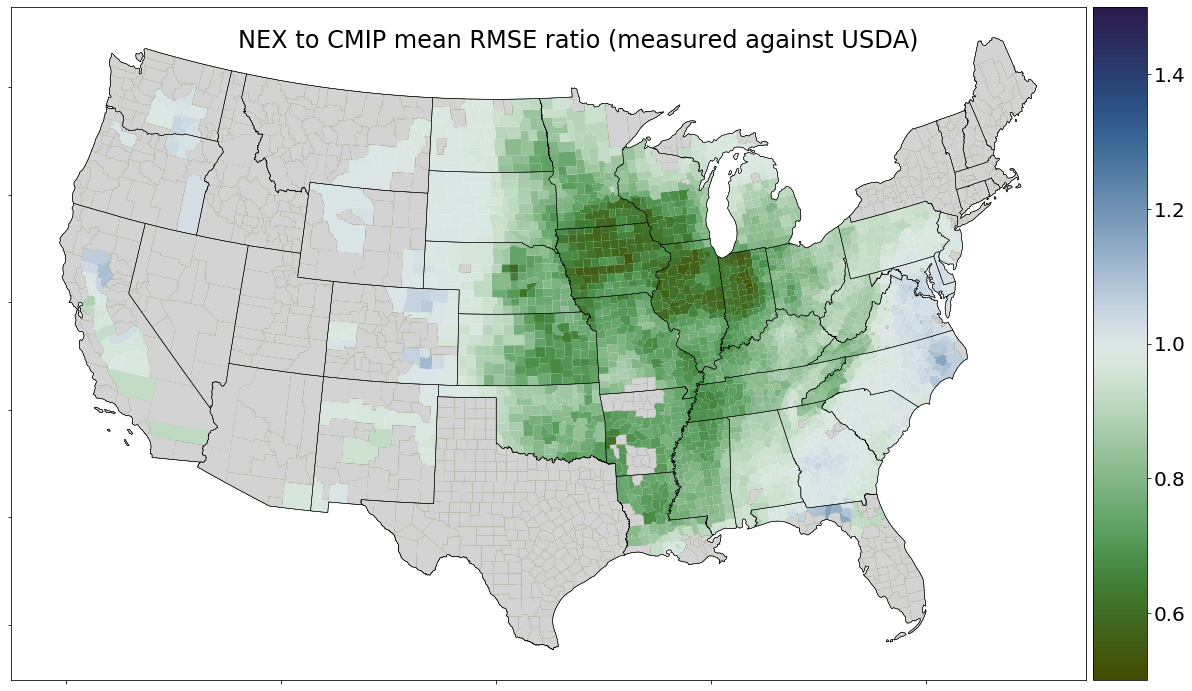

In [47]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.plot(column = "RMSE_mean_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.5, vmax = 1.5)
all_shp[all_shp.RMSE_mean_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
ax.set_title("Ensemble Mean; Yield RMSE ratio")
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.show()
# plt.savefig("map_hind_rmse_ratio_USDA.png", dpi = 500)

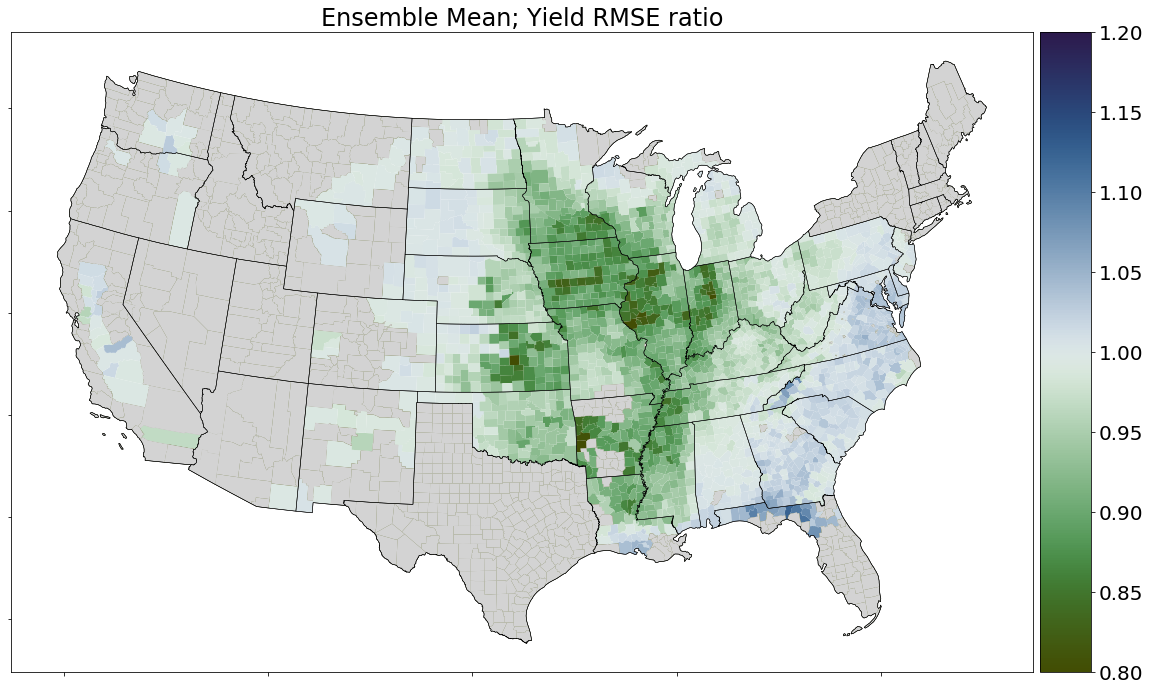

In [19]:
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.plot(column = "ensemble_mean_RMSE_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.8, vmax = 1.2)
all_shp[all_shp.RMSE_mean_ratio.isna()].plot(ax = ax, color = "lightgray")
ax.tick_params(labelbottom=False, labelleft = False)
ax.set_title("Ensemble Mean; Yield RMSE ratio")
states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.savefig("./output/figs/em_yield_rmse_ratio.png", dpi = 500)

In [ ]:
###################### 2D plot

In [112]:
usda.head()

year asd_code  Value     area  log_Value  lowess_log_Value  target_Value  \
0  1950       40   17.0  29600.0   2.833213          2.922636     -0.089422   
1  1950       40   11.0  24200.0   2.397895          2.684326     -0.286430   
2  1950       40   13.0  44200.0   2.564949          2.724326     -0.159377   
3  1950       40   23.0  38900.0   3.135494          3.057709      0.077785   
4  1950       40   16.0  23900.0   2.772589          2.724703      0.047885   

   GEOID  
0  01001  
1  01011  
2  01047  
3  01051  
4  01063

In [113]:
usdad = usda.set_index(["GEOID", "year"]).query("Value > 0.0 and year >= 1950").filter(["target_Value"])

In [114]:
usdad.head()

target_Value
GEOID year              
01001 1950     -0.089422
01011 1950     -0.286430
01047 1950     -0.159377
01051 1950      0.077785
01063 1950      0.047885

In [117]:
def analyse_rmse_nSD(data):
    # Merge with USDA
    data_all = pd.merge(data.reset_index(), usda.filter(["target_Value", "GEOID", "year", "Value"]), left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner", copy = False)
#     data_all = pd.merge(data.reset_index(), usdad.reset_index(), left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner", copy = False)

    del data_all["year"]
    data_all.set_index(["GEOID","Year"], inplace = True)
    
    # Create new geopandas dataframe for analysis. Only take counties with non-zero yield reported
    data_all = data_all.query("Value > 0.0")
    del data_all["Value"]
    data_all["count"] = 1

    # Calculate RMSE and SD
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "count")])
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_all[model_RMSE] = (data_all[model] - data_all["target_Value"])**2
        data_all[model_nSD] = (data_all[model] - data_all[model].mean(level = ["GEOID"]))**2
        del data_all[model]
    
    data_an = data_all.groupby(["GEOID"]).sum()
    data_an = data_an.query("count >= 40")
    
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_an[model_RMSE] = data_an[model_RMSE] / data_an["count"]
        data_an[model_RMSE] = np.sqrt(data_an[model_RMSE])
        
        data_an[model_nSD] = data_an[model_nSD] / data_an["target_Value_nSD"]
        data_an[model_nSD] = np.sqrt(data_an[model_nSD])
    
    del data_an["count"]
    del data_an["target_Value_RMSE"]
    del data_an["target_Value_nSD"]
    
    return data_an

In [31]:
# Stats calulator
def analyse_RMSE_gmfd(data):
    # Merge with gmfd
    data_all = pd.merge(data.query("Year <= 2005").reset_index(), usda.filter(["year","GEOID","target_Value"]).query("year <= 2005").reset_index(), left_on = ["GEOID","Year"], right_on = ["GEOID","year"], how = "inner", copy = False)

    data_all.set_index(["GEOID","Year"], inplace = True)
    data_all["count"] = 1
    
    # Calculate RMSE and SD
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "count")])
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_all[model_RMSE] = (data_all[model] - data_all["target_Value"])**2
        data_all[model_nSD] = (data_all[model] - data_all[model].mean(level = ["GEOID"]))**2
        del data_all[model]
        
    data_an = data_all.groupby(["GEOID"]).sum()
    
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_an[model_RMSE] = data_an[model_RMSE] / data_an["count"]
        data_an[model_RMSE] = np.sqrt(data_an[model_RMSE])
        
        data_an[model_nSD] = data_an[model_nSD] / data_an["target_Value_nSD"]
        data_an[model_nSD] = np.sqrt(data_an[model_nSD])
    
    del data_an["count"]
    del data_an["target_Value_RMSE"]
    del data_an["target_Value_nSD"]
    
    return data_an

In [62]:
cmipd = cmip.diff().dropna()

In [63]:
nexd = nex.diff().dropna()

In [68]:
cmip_an = analyse_rmse_nSD(cmipd)
nex_an = analyse_rmse_nSD(nexd)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [69]:
usda_weights = pd.read_csv("../national/usda_county_to_national_weights.csv")
usda_weights["GEOID"] = usda_weights["GEOID"].astype(str).str.zfill(5)

In [70]:
nex_all = pd.merge(nex_an.reset_index(), usda_weights.groupby("GEOID").mean().filter(["GEOID","national_weight"]), on = ["GEOID"], how = "inner", copy = False).drop_duplicates()
cmip_all = pd.merge(cmip_an.reset_index(), usda_weights.groupby("GEOID").mean().filter(["GEOID","national_weight"]), left_on = ["GEOID"], right_on = ["GEOID"], how = "inner", copy = False).drop_duplicates()

In [71]:
nex_all.head()

GEOID  ACCESS1-0_RMSE  ACCESS1-0_nSD  BNU-ESM_RMSE  BNU-ESM_nSD  \
0  01001        0.562127       0.536706      0.545228     0.456063   
1  01003        0.436161       0.540139      0.437508     0.486052   
2  01005        0.508076       0.529549      0.487350     0.474082   
3  01007        0.586363       0.480452      0.523959     0.433869   
4  01009        0.450927       0.551383      0.433289     0.441449   

   CCSM4_RMSE  CCSM4_nSD  CESM1-BGC_RMSE  CESM1-BGC_nSD  CNRM-CM5_RMSE  ...  \
0    0.543311   0.424668        0.523885       0.410827       0.604742  ...   
1    0.452478   0.507390        0.445385       0.583042       0.501426  ...   
2    0.552246   0.515815        0.488646       0.468207       0.592903  ...   
3    0.549986   0.383603        0.569061       0.361214       0.598059  ...   
4    0.458118   0.425064        0.449669       0.384663       0.483122  ...   

   MRI-CGCM3_nSD  NorESM1-M_RMSE  NorESM1-M_nSD  bcc-csm1-1_RMSE  \
0       0.373986        0.685615       0.500483         0.622591   
1       0.550661        0.531906       0.646695         0.479020   
2       0.361335        0.643369       0.541521         0.580271   
3       0.423589        0.712004       0.511477         0.624728   
4       0.464708        0.545504       0.494615         0.471134   

   bcc-csm1-1_nSD  inmcm4_RMSE  inmcm4_nSD  ensemble_mean_RMSE  \
0        0.475436     0.639414    0.667676            0.536571   
1        0.519153     0.473756    0.734230            0.408610   
2        0.528430     0.554034    0.717951            0.484338   
3        0.444684     0.639029    0.610188            0.554858   
4        0.438264     0.490921    0.617134            0.418140   

   ensemble_mean_nSD  national_weight  
0           0.122789         0.000055  
1           0.181092         0.000209  
2           0.143192         0.000099  
3           0.119100         0.000020  
4           0.132594         0.000102  

[5 rows x 46 columns]

In [72]:
for model in nex_all.columns.drop(["GEOID", "national_weight"]):
    nex_all[model] = nex_all[model] * nex_all["national_weight"]

In [73]:
for model in cmip_all.columns.drop(["GEOID", "national_weight"]):
    cmip_all[model] = cmip_all[model] * cmip_all["national_weight"]

In [74]:
nex_res = nex_all.sum()[1:-1]

In [74]:
nex_res.to_csv("./output/data/nex_yield_stats.csv")

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [77]:
cmip_res = cmip_all.sum()[1:-1]

In [75]:
cmip_res.to_csv("./output/data/cmip_yield_stats.csv")

/Users/davidlafferty/anaconda3/envs/geoP/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


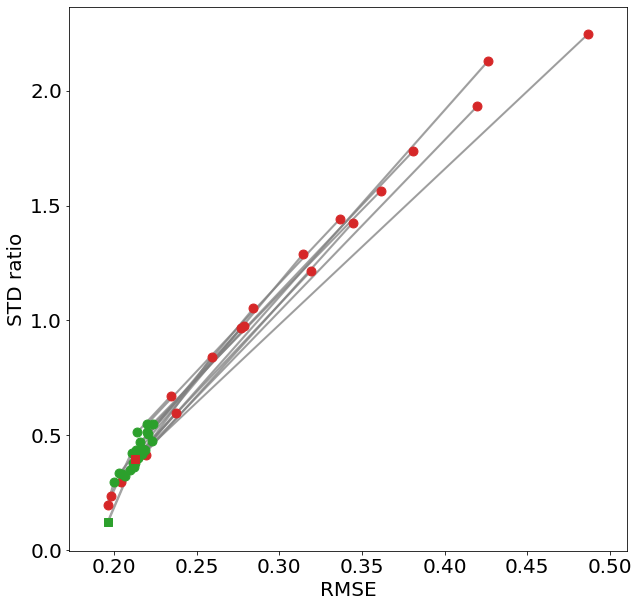

In [72]:
# Plot improvement
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.scatter(cmip_res[:-2:2],cmip_res[1:-2:2],c = "C3",s=80,zorder=2)
plt.scatter(nex_res[:-2:2],nex_res[1:-2:2],c = "C2",s=80,zorder=2)

plt.scatter(cmip_res[-2],cmip_res[-1],c = "C3",s=80,marker="s",zorder=2)
plt.scatter(nex_res[-2],nex_res[-1],c = "C2",s=80,marker="s",zorder=2)
for i in range(int(len(cmip_res)/2)):
    ax.arrow(cmip_res[::2][i], cmip_res[1::2][i], -cmip_res[::2][i]+nex_res[::2][i], -cmip_res[1::2][i]+nex_res[1::2][i],color="grey",zorder=1,alpha=0.6)
ax.set_xlabel("RMSE")
ax.set_ylabel("STD ratio")
plt.show()

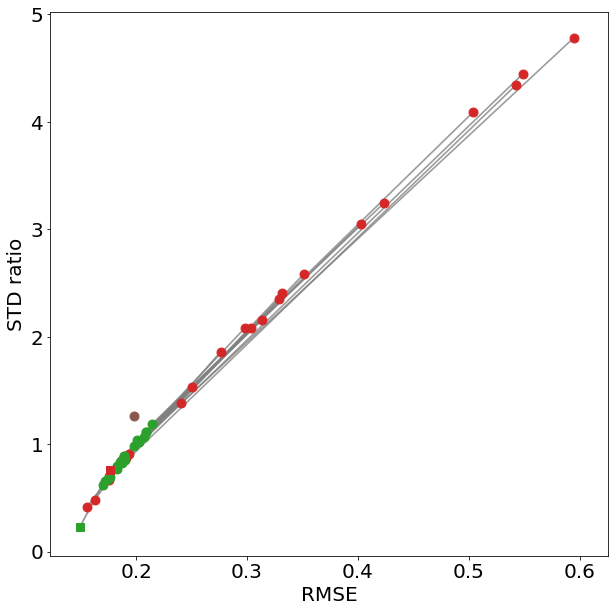

In [96]:
# Plot improvement
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.scatter(cmip_res[:-2:2],cmip_res[1:-2:2],c = "C3",s=80,zorder=2)
plt.scatter(nex_res[:-2:2],nex_res[1:-2:2],c = "C2",s=80,zorder=2)

plt.scatter(gmfd_final["projected_offset_RMSE"],gmfd_final["projected_offset_nSD"],c = "C5",s=80,zorder=2)

plt.scatter(cmip_res[-2],cmip_res[-1],c = "C3",s=80,marker="s",zorder=2)
plt.scatter(nex_res[-2],nex_res[-1],c = "C2",s=80,marker="s",zorder=2)
for i in range(int(len(cmip_res)/2)):
    ax.arrow(cmip_res[::2][i], cmip_res[1::2][i], -cmip_res[::2][i]+nex_res[::2][i], -cmip_res[1::2][i]+nex_res[1::2][i],color="grey",zorder=1,alpha=0.6)
ax.set_xlabel("RMSE")
ax.set_ylabel("STD ratio")
plt.show()

In [99]:
gmfd.set_index(["GEOID", "Year"], inplace = True)

In [100]:
gmfdd = gmfd.diff().dropna()

In [120]:
gmfd_an = analyse_rmse_nSD(gmfd)

/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

In [121]:
gmfd_all = pd.merge(gmfd_an.reset_index(), usda_weights.groupby("GEOID").mean().filter(["GEOID","national_weight"]), on = ["GEOID"], how = "inner", copy = False).drop_duplicates()

In [122]:
gmfd_all.head()

GEOID  projected_offset_RMSE  projected_offset_nSD  national_weight
0  01001               0.313353              0.413559         0.000055
1  01003               0.243177              0.640664         0.000209
2  01005               0.263001              0.538017         0.000099
3  01007               0.337002              0.410655         0.000020
4  01009               0.218143              0.477634         0.000102

In [123]:
gmfd_all["projected_offset_nSD"] = gmfd_all["projected_offset_nSD"] * gmfd_all["national_weight"]
gmfd_all["projected_offset_RMSE"] = gmfd_all["projected_offset_RMSE"] * gmfd_all["national_weight"]

In [124]:
gmfd_final = gmfd_all.sum()[1:-1]

In [125]:
gmfd_final

projected_offset_RMSE    0.159644
projected_offset_nSD     0.562052
dtype: float64